In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import string

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
# Для lstm

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df = pd.read_csv("/content/spamraw.csv")
df.head()

,type,text
0,ham,Hope you are having a good week. Just checking in
1,ham,K..give back my thanks.
2,ham,Am also doing in cbe only. But have to pay.
3,spam,"complimentary 4 STAR Ibiza Holiday or £10,000 ..."
4,spam,okmail: Dear Dave this is your final notice to...


In [ ]:
df['type'].value_counts()

type
ham     4812
spam     747
Name: count, dtype: int64

In [ ]:
df['type'].replace({'ham':0, 'spam':1}, inplace = True)

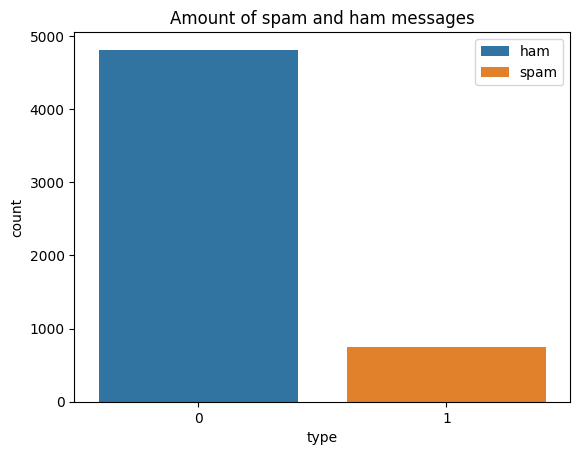

In [ ]:
sns.countplot(data = df, x= df["type"], hue = df['type']).set_title("Amount of spam and ham messages")
plt.legend(['ham', 'spam'])
plt.show()

In [ ]:
df["nwords"] = df["text"].apply(lambda s: len(re.findall(r"\w+", s)))
df["message_len"] = df["text"].apply(len)

def is_url(text):
    if re.search(r'(www\.|http[s]?://)[^\s]+', text):
        return 1
    else:
        return 0


df['is_url'] = df['text'].apply(is_url)
df

,type,text,nwords,message_len,is_url
0,0,Hope you are having a good week. Just checking in,10,49,0
1,0,K..give back my thanks.,5,23,0
2,0,Am also doing in cbe only. But have to pay.,10,43,0
3,1,"complimentary 4 STAR Ibiza Holiday or £10,000 ...",22,149,0
4,1,okmail: Dear Dave this is your final notice to...,27,161,0
...,...,...,...,...,...
5554,0,You are a great role model. You are giving so ...,57,245,0
5555,0,"Awesome, I remember the last time we got someb...",17,88,0
5556,1,"If you don't, your prize will go to another cu...",33,145,1
5557,1,"SMS. ac JSco: Energy is high, but u may not kn...",29,154,0


In [ ]:
def remove_stopwords(text):
    filtered_text = []
    for word in text.split():
        if word.lower() not in stopwords.words('english'):
            filtered_text.append(word.lower())
    ft = " ".join(filtered_text)
    return ft


def remove_punctuation(text):
    for punc in string.punctuation:
        if punc in text:
            text = text.replace(punc, ' ')
    return text.strip()


def remove_non_latin_chars(text):
    latin_only = re.sub(r'[^a-zA-Z\s]', '', text)
    return latin_only

def stemming(text):
    stemmer = PorterStemmer()
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    stemmed_text = ' '.join(stemmed_words)
    return stemmed_text

In [ ]:
df['text'] = df['text'].apply(remove_punctuation)
df['text'] = df['text'].apply(remove_stopwords)
df['text'] = df['text'].apply(remove_non_latin_chars)
df['text'] = df['text'].apply(stemming)
df

,type,text,nwords,message_len,is_url
0,0,hope good week check,10,49,0
1,0,k give back thank,5,23,0
2,0,also cbe pay,10,43,0
3,1,complimentari star ibiza holiday cash need urg...,22,149,0
4,1,okmail dear dave final notic collect tenerif h...,27,161,0
...,...,...,...,...,...
5554,0,great role model give much realli wish day mir...,57,245,0
5555,0,awesom rememb last time got somebodi high firs...,17,88,0
5556,1,prize go anoth custom c www c biz p min polo l...,33,145,1
5557,1,sm ac jsco energi high u may know channel day ...,29,154,0


In [ ]:
df.describe()

,type,nwords,message_len,is_url
count,5559.000000,5559.000000,5559.000000,5559.000000
mean,0.134377,16.063860,79.781256,0.019068
std,0.341087,11.639978,59.105270,0.136777
min,0.000000,0.000000,2.000000,0.000000
25%,0.000000,7.000000,35.000000,0.000000
50%,0.000000,12.000000,61.000000,0.000000
75%,0.000000,24.000000,121.000000,0.000000
max,1.000000,190.000000,910.000000,1.000000


In [ ]:
# Сount word freq for each SMS
word_freq_ham = df[df['type'] == 0]['text'].str.split(expand=True).stack().value_counts().head(25).reset_index()
word_freq_ham.columns = ['word_in_ham', 'ham_frequency']

word_freq_spam = df[df['type'] == 1]['text'].str.split(expand=True).stack().value_counts().head(25).reset_index()
word_freq_spam.columns = ['word_in_spam', 'spam_frequency']


word_freq = pd.concat([word_freq_ham, word_freq_spam], axis=1)

word_freq

,word_in_ham,ham_frequency,word_in_spam,spam_frequency
0,u,1211,call,383
1,go,424,free,226
2,get,364,txt,183
3,call,299,u,181
4,come,298,p,161
5,ok,288,text,146
6,love,253,ur,144
7,know,249,mobil,140
8,day,248,stop,126
9,like,248,claim,115


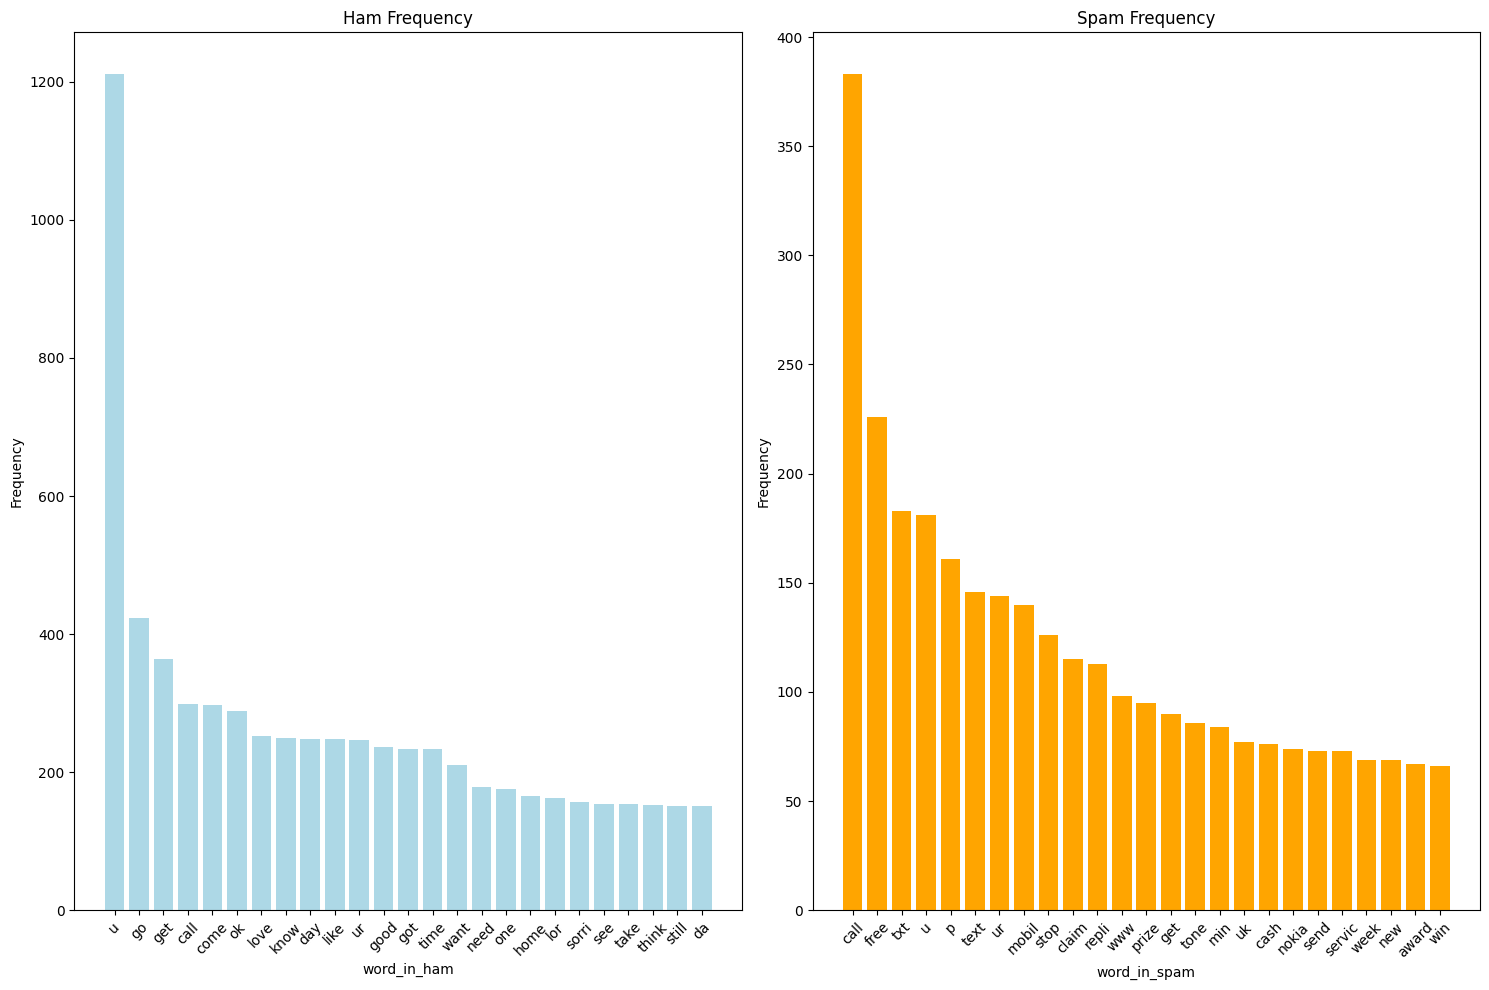

In [ ]:
plt.figure(figsize=(15, 10))

# 'ham_frequency' Diagram
plt.subplot(1, 2, 1)
plt.bar(word_freq['word_in_ham'], word_freq['ham_frequency'], color='lightblue')
plt.title('Ham Frequency')
plt.xlabel('word_in_ham')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  #

#  'spam_frequency' Diagram
plt.subplot(1, 2, 2)
plt.bar(word_freq['word_in_spam'], word_freq['spam_frequency'], color='orange')
plt.title('Spam Frequency')
plt.xlabel('word_in_spam')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
def generate_wordclouds():
    global df
    spam_text = df[df['type'] == 1]['text'].str.cat(sep=" ")
    ham_text = df[df['type'] == 0]['text'].str.cat(sep=" ")

    wc = WordCloud(width=800, height=500, min_font_size=10, background_color='white')

    # Generate a word cloud for the "Spam" category
    spam_wc = wc.generate(spam_text)
    plt.figure(figsize=(15, 6))
    plt.imshow(spam_wc, interpolation='bilinear')
    plt.title("Word Cloud for Spam")
    plt.axis('off')
    plt.show()

    # Generate a word cloud for the Ham category
    ham_wc = wc.generate(ham_text)
    plt.figure(figsize=(15, 6))
    plt.imshow(ham_wc, interpolation='bilinear')
    plt.title("Word Cloud for Ham")
    plt.axis('off')
    plt.show()

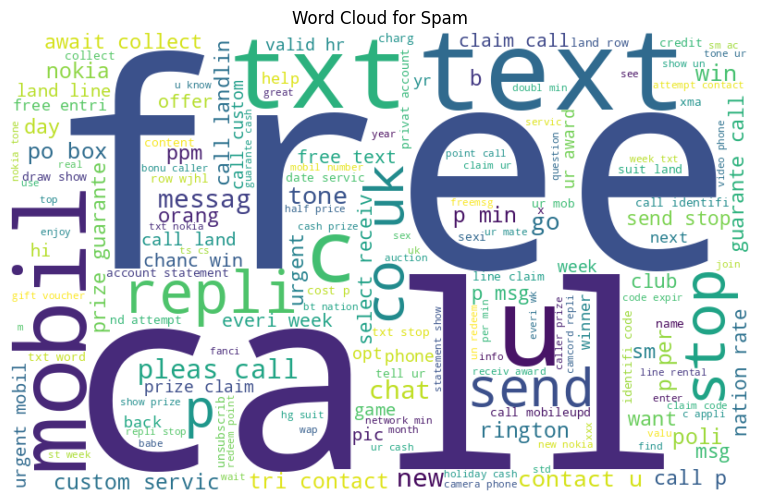

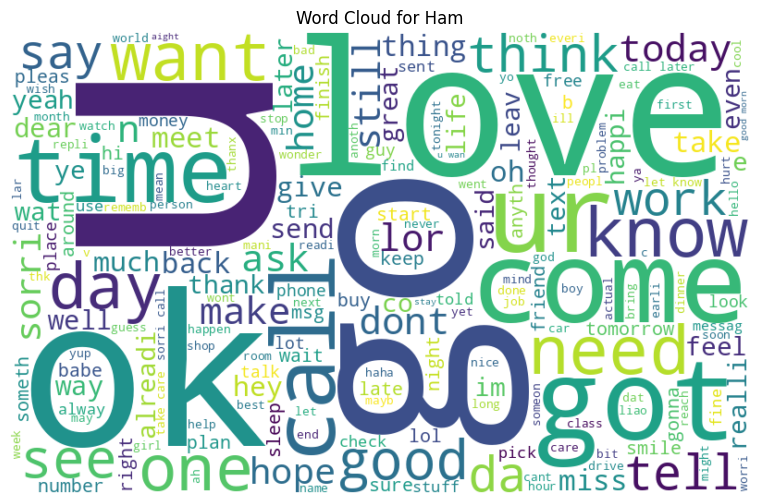

In [ ]:
generate_wordclouds()


In [ ]:
df2 = df[['text', 'type']].copy()


In [ ]:
y = df2['type']
x = df2.drop(['type'], axis = 1)
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [ ]:
num_words = 10000
maxlen = 30

In [ ]:
tokenizer = Tokenizer(num_words = num_words)
tokenizer.fit_on_texts(xtrain['text'])

In [ ]:
sequences = tokenizer.texts_to_sequences(xtrain['text'])


In [ ]:
tokenizer.word_index['call']


2

In [ ]:
xtrain = pad_sequences(sequences, maxlen=maxlen)


In [ ]:
xtrain[1234]


array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,   45,  575,   83, 1849,  573,   83,  147,
         77, 1683,  349,   44,    6, 1895,   11,  811], dtype=int32)

In [ ]:
model = Sequential() #  Creates a linear sequence of layers in a neural network.
model.add(Embedding(num_words, 64)) #  num_words - dictionary size | 64 - vector embedding size
model.add(LSTM(128)) # 128 cells
model.add(Dense(1, activation='sigmoid')) # 1 output neuron, sigmoid - neuron function activation

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_save_path = 'best_model.keras'
checkpoint_callback = ModelCheckpoint(model_save_path,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [ ]:
history = model.fit(xtrain,
                    ytrain,
                    epochs=5,
                    batch_size=128, # mini-sample size
                    validation_split=0.1, # 10% of the datased will be used for validation
                    callbacks=[checkpoint_callback])

Epoch 1/5
32/32 [==============================] - ETA: 0s - loss: 0.4045 - accuracy: 0.8446
Epoch 1: val_accuracy improved from -inf to 0.90787, saving model to best_model.keras
32/32 [==============================] - 8s 138ms/step - loss: 0.4045 - accuracy: 0.8446 - val_loss: 0.1822 - val_accuracy: 0.9079
Epoch 2/5
31/32 [============================>.] - ETA: 0s - loss: 0.1331 - accuracy: 0.9640
Epoch 2: val_accuracy improved from 0.90787 to 0.98427, saving model to best_model.keras
32/32 [==============================] - 3s 104ms/step - loss: 0.1330 - accuracy: 0.9638 - val_loss: 0.0468 - val_accuracy: 0.9843
Epoch 3/5
31/32 [============================>.] - ETA: 0s - loss: 0.0512 - accuracy: 0.9877
Epoch 3: val_accuracy improved from 0.98427 to 0.99101, saving model to best_model.keras
32/32 [==============================] - 3s 101ms/step - loss: 0.0517 - accuracy: 0.9875 - val_loss: 0.0300 - val_accuracy: 0.9910
Epoch 4/5
32/32 [==============================] - ETA: 0s - los

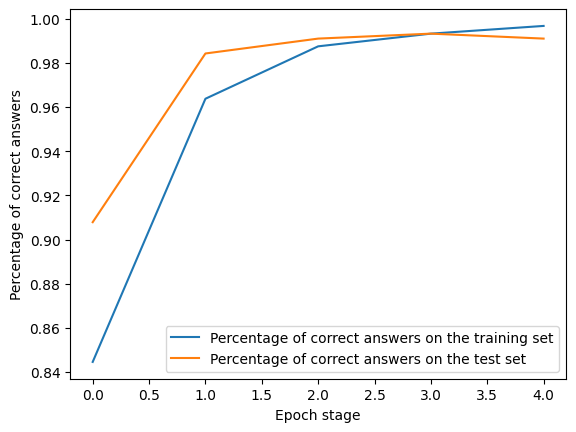

In [ ]:
plt.plot(history.history['accuracy'], label='Percentage of correct answers on the training set')
plt.plot(history.history['val_accuracy'], label='Percentage of correct answers on the test set')
plt.xlabel('Epoch stage')
plt.ylabel('Percentage of correct answers')
plt.legend()
plt.show()

In [ ]:
model.load_weights(model_save_path)

In [ ]:
test_sequences = tokenizer.texts_to_sequences(xtest['text'])
xtest = pad_sequences(test_sequences, maxlen = maxlen)

In [ ]:
model.evaluate(xtest, ytest, verbose=1)

35/35 [==============================] - 1s 32ms/step - loss: 0.0629 - accuracy: 0.9838


[0.06285657733678818, 0.9838129281997681]

In [ ]:
def spam_check(text):
    print(text)
    sequence = tokenizer.texts_to_sequences([text])
    data = pad_sequences(sequence, maxlen=maxlen)
    result = model.predict(data)
    print(result)
    if result[[0]] < 0.05:
        print('ham')
    else:
        print('spam')

In [ ]:
spam_check(df['text'][10])


sure thing big man hockey elect shouldnt go longer hour though
1/1 [==============================] - 0s 490ms/step
[[0.0014677]]
ham


35/35 [==============================] - 1s 15ms/step


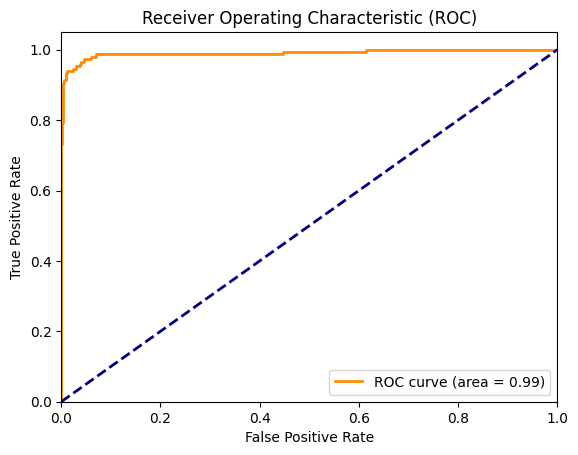

In [ ]:
# Getting model predictions for test data
y_pred = model.predict(xtest).ravel()

# ROC curve calculation
fpr, tpr, thresholds = roc_curve(ytest, y_pred)
roc_auc = auc(fpr, tpr)

# Вывод ROC кривой
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()